# Exploring Bavarian results of the EU election 2024 open data with Jayvee
The EU publishes large amounts of open data. They re-use their own open data to allow citizens to gain insights into the EU elections 2024 (see, for example, [these news](https://data.europa.eu/en/news-events/news/eu-election-results-are-here-learn-how-votes-are-distributed)).

Based on published open data, citizens can run their own analysis. Sadly, the published data is not easy to use. With Jayvee, we can easily model a data pipeline that allows us to extract, clean and transform data and finally save it in a SQLite database for further use.

## Import needed libraries

In [6]:
import subprocess
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Extract, clean and transform EU election data with Jayvee
- The data pipeline modeled in [eu-elections.jv](./eu-elections.jv) extracts open data about the EU election 2024 from [bundeswahlleiterin.de](https://www.bundeswahlleiterin.de/)
- First, we install a specific Jayvee interpreter (version 0.5.0) locally with npm
- Second, we run execute the Jayvee model using the previously installed interpreter
- The Jayvee data pipeline extracts, cleans and transforms the data, so it is easier to use in follow-up analysis. Election data is filtered to Bavarian regions and written into a SQLite file

In [2]:
%%capture
subprocess.run(["npm", "install", "@jvalue/jayvee-interpreter@0.5.0"], stdout=subprocess.DEVNULL) 

In [13]:
%%capture

subprocess.run(["npx", "jv", "-d", "eu-elections.jv"]) 

[EuElectionsGermany] Overview:
	Blocks (16 blocks with 1 pipes):
	 -> GermanResultsFile (HttpExtractor)
		 -> InterpretAsText (TextFileInterpreter)
			 -> RemoveComments (TextRangeSelector)
				 -> ParseAsCSV (CSVInterpreter)
					 -> WriteRegionHeader (CellWriter)
						 -> WritePartyHeaders (CellWriter)
							 -> ParseAsTable (TableInterpreter)
								 -> CSUDiff (TableTransformer)
									 -> GrueneDiff (TableTransformer)
										 -> SPDDiff (TableTransformer)
											 -> AfDDiff (TableTransformer)
												 -> CSUPercentage (TableTransformer)
													 -> GruenePercentage (TableTransformer)
														 -> SPDPercentage (TableTransformer)
															 -> AfDPercentage (TableTransformer)
																 -> LoadIntoSQLite (SQLiteLoader)

	[GermanResultsFile] Fetching raw data from https://www.bundeswahlleiterin.de/europawahlen/2024/ergebnisse/opendata/ew24/csv/kerg.csv
	[GermanResultsFile] Successfully fetched raw data
	[GermanResultsFile] Execution duration: 222

## Inspect the improved data
- Now we can use the improved open data for follow-up analysis
- We load the data from SQLite into a dataframe and print it to visually inspect the data

In [14]:
with sqlite3.connect("./eu-elections.sqlite") as connection:
    df = pd.read_sql_query("SELECT * FROM elections2019_2024", connection)

df

,Id,Region,Grüne 2024,Grüne 2019,SPD 2024,SPD 2019,AfD 2024,AfD 2019,CSU 2024,CSU 2019,CSU Diff,Grüne Diff,SPD Diff,AfD Diff,CSU Diff (%),Grüne Diff (%),SPD Diff (%),AfD Diff (%)
0,09161,"Ingolstadt, kreisfreie Stadt",5912,9086,4766,4212,6925,5198,19555,18180,1375,-3174,554,1727,8.0,-35.0,13.0,33.0
1,09162,"München, Landeshauptstadt",150919,189175,76279,69403,42410,36282,172295,163350,8945,-38256,6876,6128,5.0,-20.0,10.0,17.0
2,09163,"Rosenheim, kreisfreie Stadt",3931,5184,2571,2227,3012,2241,8950,8480,470,-1253,344,771,6.0,-24.0,15.0,34.0
3,09171,Altötting,3895,6449,3683,3589,7866,4051,21887,22900,-1013,-2554,94,3815,-4.0,-40.0,3.0,94.0
4,09172,Berchtesgadener Land,4303,7178,3172,3179,6225,3802,18956,20329,-1373,-2875,-7,2423,-7.0,-40.0,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,09776,Lindau (Bodensee),5240,8863,3565,3023,4326,2454,15459,13873,1586,-3623,542,1872,11.0,-41.0,18.0,76.0
92,09777,Ostallgäu,7289,11561,4744,4198,9191,4789,32243,29243,3000,-4272,546,4402,10.0,-37.0,13.0,92.0
93,09778,Unterallgäu,5306,9316,4113,3810,12186,6401,30997,28551,2446,-4010,303,5785,9.0,-43.0,8.0,90.0
94,09779,Donau-Ries,4895,8139,4847,4771,8719,4828,31640,29819,1821,-3244,76,3891,6.0,-40.0,2.0,81.0


## Find regions that had large shifts in voting behaviors by party
- Calculate differences by region for parties and display regions with the largest differences

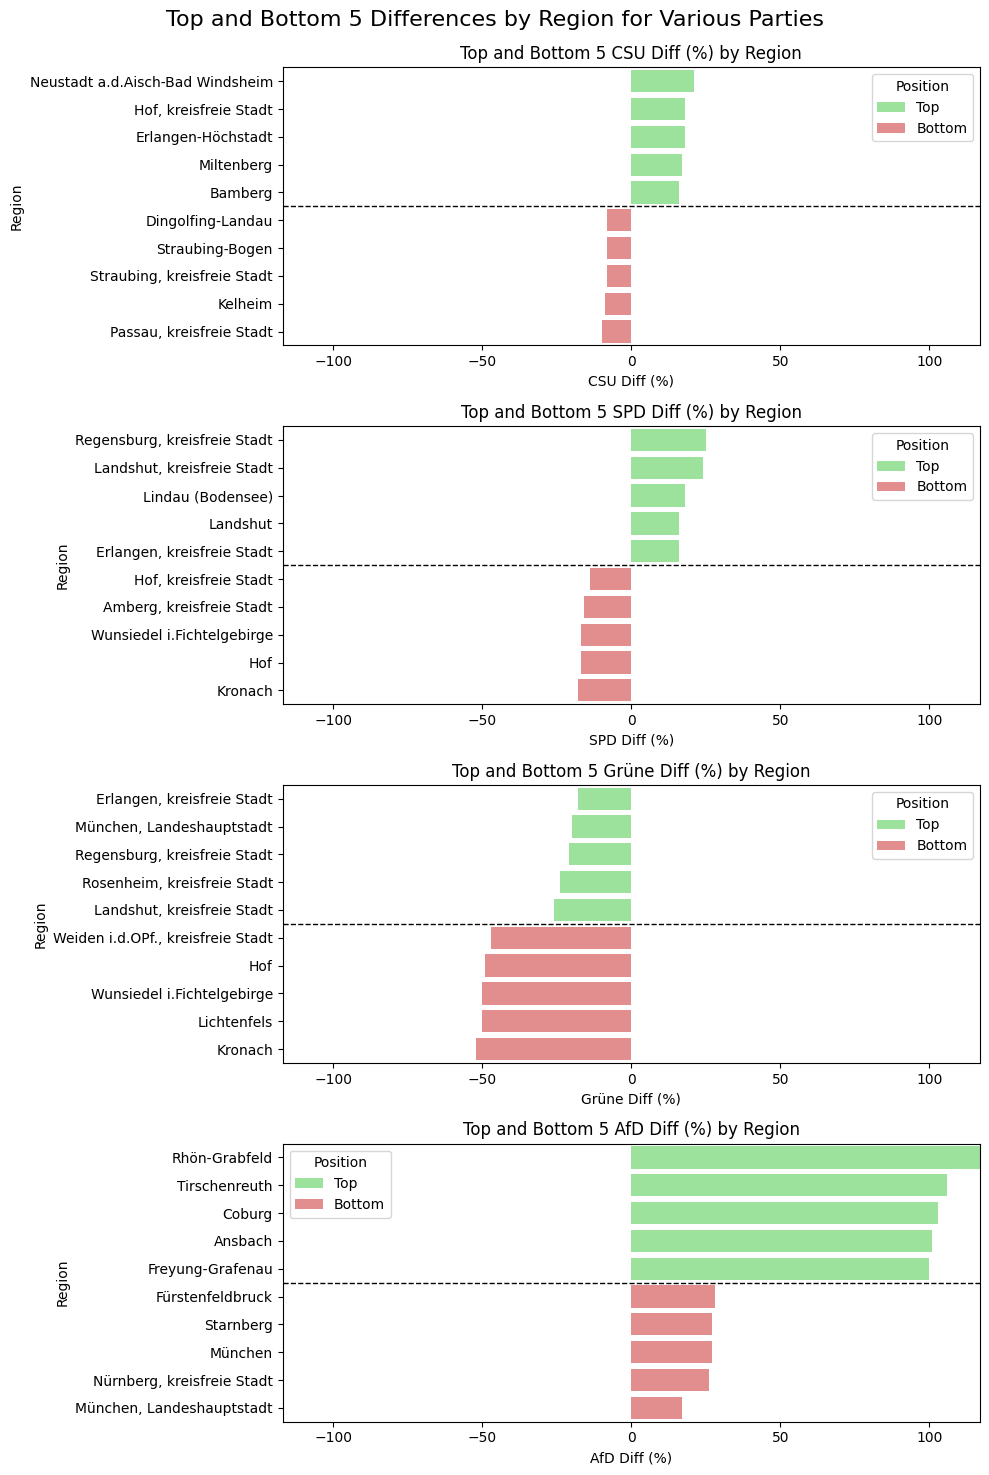

In [16]:
# The following code has been partically generated with ChatGPT and adjusted by a human ;)
# Define parties and their respective columns
parties = ["CSU", "SPD", "Grüne", "AfD"]
columns = [f"{party} Diff (%)" for party in parties]
max_val = max(df[columns].abs().max())

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Top and Bottom 5 Differences by Region for Various Parties", fontsize=16)

# Plot top and bottom values for each party
for i, col in enumerate(columns):
    top_5 = df.nlargest(5, col)
    bottom_5 = df.nsmallest(5, col).iloc[::-1]
    
    # Concatenate top and bottom 5
    combined = pd.concat([top_5, bottom_5])
    combined["Position"] = ["Top"]*5 + ["Bottom"]*5
    
    # Plot combined data
    sns.barplot(x=col, y="Region", hue="Position", data=combined, dodge=False, ax=axes[i], palette=["lightgreen", "lightcoral"])
    axes[i].set_title(f"Top and Bottom 5 {parties[i]} Diff (%) by Region")
    axes[i].set_xlabel(f"{parties[i]} Diff (%)")
    axes[i].set_ylabel("Region")
    
    # Add a divider line
    divider_position = 4.5
    axes[i].axhline(y=divider_position, color="black", linewidth=1, linestyle="--")
    
    # Set symmetrical x-axis limits
    axes[i].set_xlim(-max_val, max_val)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()